# Chapter 6: Climate Oscillations

This chapter delves into two of the most renowned climate oscillations: the El Niño-Southern Oscillation (ENSO) and the North Atlantic Oscillation (NAO). ENSO is an ocean-atmosphere oscillation in the tropical Pacific Ocean with a period spanning 2-7 years, while the NAO operates in the North Atlantic Ocean over a period of 5-10 years. Both these oscillations considerably influence the climate of nearby continents. In this chapter, we'll investigate how to formulate indices that represent the state of these climate oscillations. Additionally, we'll briefly delve into how one might identify teleconnections, using surface temperature teleconnections of ENSO as an illustrative example.

<div class="alert alert-block alert-success">
<b>Objective:</b> <br>
   Craft indices for ENSO and NAO climate oscillations analogous to <a href="https://climate.copernicus.eu/climate-indicators/sea-surface-temperature#ptab-0-2-content">Figure 5</a> in <a href="https://climate.copernicus.eu/climate-indicators/sea-surface-temperature">Climate Indicators/Sea Surface Temperature</a> and Figure 3 in <a href="https://climate.copernicus.eu/esotc/2022/atmospheric-circulation">ESOTC 2022/Atmospheric Circulation</a>. Afterwards, explore the teleconnections of ENSO.
</div>

<div class="alert alert-block alert-warning">
<b>Caution</b>: <br>
   This notebook is notably data-heavy and necessitates roughly 20 GB of free disk space. Cells in the notebook that initiate a download will be preceded by a warning cell.
</div>

<div class="alert alert-block alert-info">    
<b>NOTE</b>: 
Before interacting with the following notebook, please ensure you've reviewed the <a href="https://ecmwfcode4earth.github.io/sketchbook-earth/how_to_run_notebooks.html">How to Execute the Notebooks</a> section.
</div>

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

## Importing Packages

Begin by importing the requisite packages for this tutorial.

In [1]:
# API and system utilities
import cdsapi
import os

# Data manipulation and computation
import xarray as xr
import numpy as np
import dask
import datetime as dt

# Data visualization and plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# EOF analysis
import xeofs as xe

# Progress bars and diagnostics
from tqdm.notebook import tqdm
from dask.diagnostics import ProgressBar

Execute the cell below to adopt this book's visualisation style. This ensures consistency in visual presentations throughout the notebook. Note, this solely pertains to visualisation and doesn't affect the underlying calculations. If using GoogleColab, the matplotlib stylesheet won't be unavailable.

In [2]:
plt.style.use("../copernicus.mplstyle")

To optimise `dask`'s [performance](https://docs.dask.org/en/latest/understanding-performance.html), avoid generating large `dask` chunks.

In [3]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

## Getting Started

Establish the reference period which characterises the climatology of our datasets.

In [4]:
REF_PERIOD = dict(time=slice('1991', '2020'))

We'll also define a set of projections for `cartopy` to be used subsequently.

In [5]:
proj = {
    "data": ccrs.PlateCarree(),
    "map_global": ccrs.Robinson(central_longitude=180),
    "map_north_atlantic": ccrs.Orthographic(central_longitude=-20, central_latitude=60),
}

Moving forward, set up a data directory to neatly store our files.

In [6]:
path_to = {}  # dictionary containing [<variable> : <target folder>]

path_to.update({"temp": "data/temp/era5_temp.nc"})
path_to.update({"temp_anomalies": "data/temp/era5_temp_anomalies.nc"})
path_to.update({"gph": "data/gph/era5_gph.nc"})

for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<20} --> {}".format(file, path))

temp                 --> data/temp/era5_temp.nc
temp_anomalies       --> data/temp/era5_temp_anomalies.nc
gph                  --> data/gph/era5_gph.nc


## ENSO Index

Our first step is to derive the ENSO index using sea surface temperature (SST) data from the ERA5 reanalysis. While there are [multiple methods](https://www.weather.gov/fwd/indices) to derive the ENSO index, our approach utilises the NINO3.4 index. This index denotes the average SST anomalies within the region 5°S-5°N, 170°W-120°W.

### Downloading Data
Kick off by downloading the data from the [Climate Data Store](https://doi.org/10.24381/cds.f17050d7) (CDS). We're particularly interested in the monthly averaged SST data from ERA5 reanalysis. The CDS API is our tool of choice for this download. Given that the NINO3.4 index is constrained to a specific spatial region, one might consider downloading only this section. Yet, since our aim is to later probe the surface temperature teleconnections of ENSO, we'll encompass global data. This includes downloading the monthly averaged 2m temperature data from ERA5 reanalysis.
Enter your CDS API key in the cell below.

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

Please input your CDS API key in the subsequent cell.

In [7]:
##### ERA5 reanalysis
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################' # add your key here the format should be as {uid}:{api-key}

Now, let's initiate the data download.

<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
   The upcoming cell will download approximately 4 GB. Ensure you have sufficient storage space. Depending on your internet speed, this could take several hours.
</div>

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'sea_surface_temperature'],
    'year': list(range(1940, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
  },
  path_to['temp']
)

We'll then *lazily* load the data employing `xarray` and `dask`. Our chunks will be set by spatial dimensions rather than time, considering our calculations will operate along the time axis.

In [9]:
temperatures = xr.open_mfdataset(path_to["temp"], chunks={"time": -1, "longitude": 300, "latitude": 150})
temperatures

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 996)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(996, 150, 300), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(996, 150, 300), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-11 17:33:49 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

For simplicity's sake, rename the `longitude` and `latitude` dimensions to `lon` and `lat`, respectively.

In [10]:
temperatures = temperatures.rename({'longitude': 'lon', 'latitude': 'lat'})

### Compute Anomalies

Next, ascertain the monthly climatologies for both datasets across each grid cell. These climatologies will be instrumental in computing the anomalies.

In [12]:
climatologies = temperatures.sel(REF_PERIOD).groupby("time.month").mean()

with ProgressBar():
    climatologies = climatologies.compute()

[########################################] | 100% Completed | 10.40 s


The ensuing cell calculates the temperature anomalies.

In [18]:
anomalies = temperatures.groupby("time.month") - climatologies

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]


A major advantage of `dask` is its capacity to sequence operations until our processed dataset snugly fits into our memory. Nevertheless, repeatedly computing the same `dask` `DataArray` can be inefficient. To counter this, we'll compute this intermediary result, archive it on our disk, and then lazily fetch it for additional processing.

In [14]:
with ProgressBar():
    anomalies.to_netcdf(path_to["temp_anomalies"])

[########################################] | 100% Completed | 199.55 s


Now, let's reload the temperature anomalies:

In [7]:
anomalies = xr.open_dataset(path_to["temp_anomalies"], chunks={"time": -1, "lon": 300, "lat": 150})

For ease, extract the anomalies of the global surface temperature at 2m (`t2m`) and the sea surface temperature (`sst`), placing them in distinct variables.

In [8]:
t2m = anomalies['t2m']
sst = anomalies['sst']
sst

<xarray.DataArray 'sst' (time: 996, lat: 721, lon: 1440)>
dask.array<open_dataset-sst, shape=(996, 721, 1440), dtype=float32, chunksize=(996, 150, 300), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
    month    (time) int64 dask.array<chunksize=(996,), meta=np.ndarray>

Now, computing the NINO3.4 index is straightforward. We simply average the SST anomalies in the region 5°S-5°N, 170°W-120°W. Note that as the longitude dimensions ranges from 0 to 360°E, the region defintion translates to 190°E-240°E.

In [9]:
nino34 = sst.sel(lon=slice(190, 240), lat=slice(5, -5)).mean(dim=['lon', 'lat'])
nino34

<xarray.DataArray 'sst' (time: 996)>
dask.array<mean_agg-aggregate, shape=(996,), dtype=float32, chunksize=(996,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
    month    (time) int64 dask.array<chunksize=(996,), meta=np.ndarray>

The index's compact size ensures it comfortably fits in our memory. The cell below manages the actual computation.

In [10]:
with ProgressBar():
    nino34 = nino34.compute()

[########################################] | 100% Completed | 1.01 sms


Lastly, illustrate the NINO3.4 index.

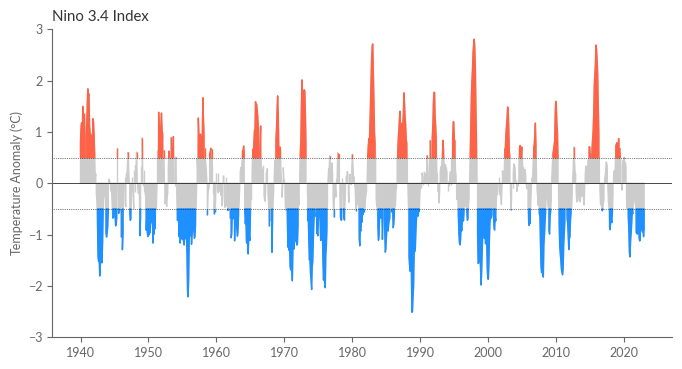

In [55]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.fill_between(nino34.time, nino34, 0, where=nino34 > 0, color='.8')
ax.fill_between(nino34.time, nino34, 0, where=nino34 < 0, color='.8')
ax.fill_between(nino34.time, nino34, 0.5, where=nino34 > 0.5, color='tomato')
ax.fill_between(nino34.time, nino34, -0.5, where=nino34 < -0.5, color='dodgerblue')
ax.axhline(0.5, color='k', linewidth=0.5, ls=':')
ax.axhline(-0.5, color='k', linewidth=0.5, ls=':')
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xlabel("")
ax.set_ylabel("Temperature Anomaly (°C)")
ax.set_ylim(-3, 3)
ax.set_title("Nino 3.4 Index")
plt.show()

### Teleconnections

Teleconnections describe the influence of a climate oscillation on the climate of a distant region. In this section, we'll delve into the teleconnections of ENSO on continental surface temperature, using the NINO3.4 index as a representative for the ENSO state. For this purpose, we'll utilise the monthly averaged 2m temperature data from the ERA5 reanalysis.

A practical method to explore these teleconnections is through correlation analysis. Specifically, we'll calculate the Pearson correlation coefficient between the NINO3.4 index and the continental surface temperatures. Typically, areas with high correlation coefficients highlight regions potentially influenced by ENSO on their surface temperatures. However, it's crucial to remember that a strong correlation doesn't necessarily imply a direct cause-and-effect relationship; spurious correlations may exist. For the sake of brevity and simplicity in this tutorial, we'll treat the Pearson correlation coefficient as an initial approximation to pinpoint possible teleconnection regions. Fortunately, `xarray` offers a convenient built-in `corr` method, enabling us to conduct this analysis seamlessly in a single line of code.

In [12]:
corr_nino34_t2m = xr.corr(nino34, t2m, dim="time")

with ProgressBar():
    corr_nino34_t2m = corr_nino34_t2m.compute()

[                                        ] | 0% Completed | 147.21 us

[########################################] | 100% Completed | 64.67 s


As a reference, let's define a rectangular box that encompasses the NINO3.4 region.

In [13]:
nino34_region = dict(
    lon=[190, 240, 240, 190, 190],
    lat=[-5, -5, 5, 5, -5]
)

Now we plot the correlation coefficient together with the NINO3.4 index region.

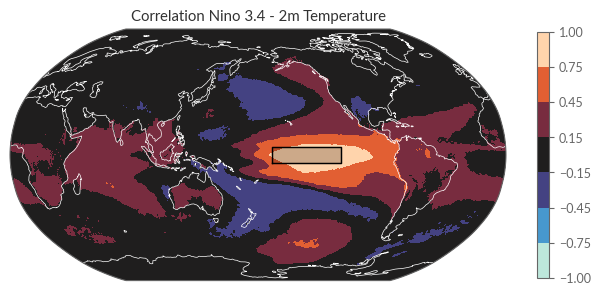

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection=proj["map_global"])
corr_nino34_t2m.plot(ax=ax, transform=proj["data"], cmap="icefire", vmin=-1, vmax=1, levels=[-1, -.75, -.45, -.15, .15, .45, .75, 1], cbar_kwargs={"shrink": 0.8})
ax.coastlines(lw=.5, color="w")
# Add Nino 3.4 region
ax.plot(nino34_region["lon"], nino34_region["lat"], transform=proj["data"], color="k", lw=1)
ax.fill(nino34_region["lon"], nino34_region["lat"], transform=proj["data"], color="k", alpha=0.2)
ax.set_title("Correlation Nino 3.4 - 2m Temperature", loc="center")
plt.show()

## NAO Index

The North Atlantic Oscillation (NAO) is a significant fluctuation in atmospheric pressure between the subtropical high-pressure system near the Azores in the Atlantic Ocean and the sub-polar low-pressure system near Iceland. It's a pivotal determinant of winter climate patterns in Europe. The NAO quantifies the strength of the westerly winds over the North Atlantic. While numerous ways exist to define the NAO index, the variations between them are generally slight.

In this section, we'll adopt the definition found in the [ESOTC 2022](https://climate.copernicus.eu/esotc/2022/about-data#NorthAtlanticOscillationIndex). 

Succinctly, the NAO index is computed as follows:

1. Empirical Orthogonal Function (EOF) analysis is conducted on daily area-weighted 500 hPa geopotential height (Z500) anomalies from the ERA5 reanalysis covering the Euro-Atlantic region (30°N to 88.5°N, 80°W to 40°E) from 1980–2008. Only data from October–April are utilised in this phase. The NAO pattern is characterised by the first mode derived from this EOF analysis.
2. A daily NAO index time series is then produced by projecting the daily Z500 anomalies from ERA5 onto the NAO pattern established in the first step. This series is subsequently standardised using its standard deviation from 1991–2020. Notably, the daily anomalies deployed in the second step are deduced from the daily climatology spanning 1991–2020.

<div class="alert alert-block alert-info">
<b>Info</b>: <br>
   For ESOTC 2022, the ERA-Interim dataset is used instead of ERA5.
</div>

### Downloading the Data

To suppress the output, we instantiate a new `cdsapi` Client.

In [88]:
c = cdsapi.Client(quiet=True, progress=False)

Given our intent to fetch daily data, it's prudent to cluster months in batches, enhancing the download efficiency. Thus, we designate the years and months for download.

In [129]:
YEARS = ["{:04d}".format(y) for y in range(1970, 2022)]
MONTHS = ["{:02d}".format(m) for m in range(1, 13)]

The [CDS](https://cds.climate.copernicus.eu/cdsapp#!/software/app-c3s-daily-era5-statistics?tab=overview) hosts an application allowing daily ERA5 statistics derivation. A comprehensive manual on this application's operation can be found [here](https://datastore.copernicus-climate.eu/documents/app-c3s-daily-era5-statistics/C3S_Application-Documentation_ERA5-daily-statistics-v2.pdf).

<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
   The upcoming cell will download approximately 9 GB. Ensure you have sufficient storage space. Depending on your internet speed, this could take several hours.
</div>

In [ ]:
for year in tqdm(YEARS, desc="Overall progress"):
    for month in tqdm(MONTHS, desc="Year {}".format(year), leave=False):
        # Define the filename and the path to save the file
        path_to_file = f"data/gph/era5_z500_{year}_{month}.nc"
        # Check if the extracted files already exist
        file_exits = os.path.exists(path_to_file)
        # Download the file only if it doesn"t exist
        if not file_exits:
            result = c.service(
                "tool.toolbox.orchestrator.workflow",
                params={
                    "realm": "user-apps",
                    "project": "app-c3s-daily-era5-statistics",
                    "version": "master",
                    "kwargs": {
                        "dataset": "reanalysis-era5-pressure-levels",
                        "product_type": "reanalysis",
                        "variable": "geopotential",
                        "statistic": "daily_mean",
                        "year": year,
                        "month": month,
                        "time_zone": "UTC+00:00",
                        "frequency": "1-hourly",
                        "grid": "0.25/0.25",
                        "pressure_level": "500",
                        "area": {"lat": [30, 88.5], "lon": [-80, 40]}
                    },
                    "workflow_name": "application"
            })
            c.download(result, targets=[path_to_file])

Next, we access the data:

In [56]:
z500 = xr.open_mfdataset("data/gph/*.nc")
z500

<xarray.Dataset>
Dimensions:      (time: 13330, lat: 235, lon: 481)
Coordinates:
  * time         (time) datetime64[ns] 1970-01-01 1970-01-02 ... 2006-06-30
    realization  int64 0
    plev         float64 5e+04
  * lat          (lat) float64 30.0 30.25 30.5 30.75 ... 87.75 88.0 88.25 88.5
  * lon          (lon) float64 -80.0 -79.75 -79.5 -79.25 ... 39.5 39.75 40.0
Data variables:
    z            (time, lat, lon) float32 dask.array<chunksize=(31, 235, 481), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2023-09-13T15:03 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

With just a singular variable at our disposal, it's straightforward to isolate it and utilise the relevant `xarray.DataArray`.

In [57]:
z500 = z500['z']
z500

<xarray.DataArray 'z' (time: 13330, lat: 235, lon: 481)>
dask.array<concatenate, shape=(13330, 235, 481), dtype=float32, chunksize=(31, 235, 481), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1970-01-01 1970-01-02 ... 2006-06-30
    realization  int64 0
    plev         float64 5e+04
  * lat          (lat) float64 30.0 30.25 30.5 30.75 ... 87.75 88.0 88.25 88.5
  * lon          (lon) float64 -80.0 -79.75 -79.5 -79.25 ... 39.5 39.75 40.0
Attributes:
    long_name:              Geopotential
    units:                  m2 s-2
    standard_name:          geopotential
    comment:                Geopotential is the sum of the specific gravitati...
    cds_magics_style_name:  turbo_1000_3000
    type:                   real

### Computing Daily Anomalies

The initial task for computing daily anomalies is establishing the daily climatology. The predefined reference period (1991-2020) will serve as our benchmark.

In [58]:
daily_climatoloy = z500.sel(REF_PERIOD).groupby("time.dayofyear").mean()
with ProgressBar():
    daily_climatoloy = daily_climatoloy.compute()

[########################################] | 100% Completed | 15.51 s


We can now proceed to calculate the daily anomalies.

In [59]:
z500_anomalies = z500.groupby("time.dayofyear") - daily_climatoloy

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 37 times more chunks
  return self.array[key]


### Deriving the NAO Index

As previously outlined, the NAO index is based on the first EOF mode of daily Z500 anomalies from October through April, spanning 1980 to 2008. First, we select this specific time period.

In [60]:
is_winter_month = z500_anomalies.time.dt.month.isin([10,11,12,1,2,3,4])
z500_nao_ref = z500_anomalies.isel(time=is_winter_month).sel(time=slice("1980-01-01", "2008-12-31"))
z500_nao_ref

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.DataArray 'z' (time: 5639, lat: 235, lon: 481)>
dask.array<getitem, shape=(5639, 235, 481), dtype=float32, chunksize=(1, 235, 481), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2006-04-30
    realization  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    plev         (time) float64 5e+04 5e+04 5e+04 5e+04 ... 5e+04 5e+04 5e+04
  * lat          (lat) float64 30.0 30.25 30.5 30.75 ... 87.75 88.0 88.25 88.5
  * lon          (lon) float64 -80.0 -79.75 -79.5 -79.25 ... 39.5 39.75 40.0
    dayofyear    (time) int64 1 2 3 4 5 6 7 8 ... 114 115 116 117 118 119 120

The next step involves conducting the EOF analysis using the `xeofs` package. To initialise the EOF model, we need to specify the number of modes to compute. As we're primarily interested in the first mode, we set this value to 1.

In [61]:
eof_model = xe.models.EOF(n_modes=1)

Next, we simply fit the model to our data. Crucially, we need to specify the dimension for the EOF analysis, which in our case is the time dimension.

In [62]:
eof_model.fit(z500_nao_ref, dim="time")

Post this, we can capture the EOF pattern and the affiliated principal component (PC). Given our input was sourced from `dask` arrays, both the EOF pattern and PC echo this format. Prior to visualisation, we therefore need to compute the results. Thankfully, `xeofs` furnishes a useful method, computing all results simultaneously.

In [63]:
eof_model.compute(verbose=True)

[########################################] | 100% Completed | 192.25 s
[########################################] | 100% Completed | 186.70 s
[########################################] | 100% Completed | 194.43 s
[########################################] | 100% Completed | 54.90 s


Subsequently, we extract the spatial patterns (components).

In [64]:
components = eof_model.components()

Examining the first EOF mode of the Z500 anomalies reveals the evident NAO pattern.

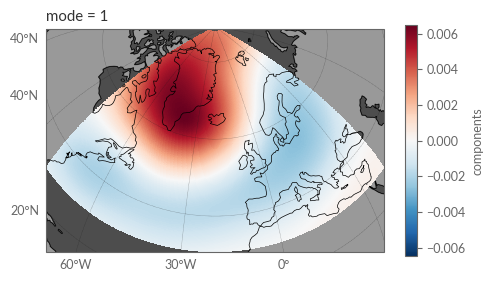

In [65]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121, projection=proj["map_north_atlantic"])
ax.coastlines(lw=.5)
ax.add_feature(cfeature.LAND, color=".6")
ax.add_feature(cfeature.OCEAN, color=".3")
gl = ax.gridlines(draw_labels=True, color='.1', ls=':', lw=.25)
gl.top_labels = False
gl.right_labels = False
components.sel(mode=1).plot(transform=ccrs.PlateCarree(), ax=ax)
plt.show()

In the following step, the NAO index's daily time series is fashioned by projecting the ERA5 daily Z500 anomalies onto the previously delineated NAO pattern. This projection is executed via the `transform` method within the `xeofs` model.

In [66]:
pseudo_pcs = eof_model.transform(z500_anomalies)

The first mode, embodying the NAO index, is selected.

In [67]:
nao_index = pseudo_pcs.sel(mode=1)

We compute the NAO index.

In [68]:
with ProgressBar():
    nao_index = nao_index.compute()

[########################################] | 100% Completed | 64.00 s


The concluding step entails standardising the NAO index using its 1991–2020 standard deviation.

In [69]:
nao_index = nao_index / nao_index.sel(REF_PERIOD).std("time")

Time to visualise the NAO index. To echo the ESOTC 2022's depiction, we craft a helper function positioning the labels aptly between the x-ticks.

In [70]:
def center_labels_between_xticks(ax):
    # set y-ticks as integers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Set major x-ticks every 1 month
    ax.xaxis.set_major_locator(dates.MonthLocator())


    # Centering labels between ticks
    # 16 is a slight approximation since months differ in number of days.
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))

    # Remove the minor tick lines
    ax.tick_params(axis="x", which="minor", tick1On=False, tick2On=False)

    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment("center")

Moreover, a 7-day rolling mean is applied, lending a smoother edge to the NAO index.

In [71]:
nao_index_smooth = nao_index.rolling(time=7, center=True).mean()

Lastly, we plot the NAO index.

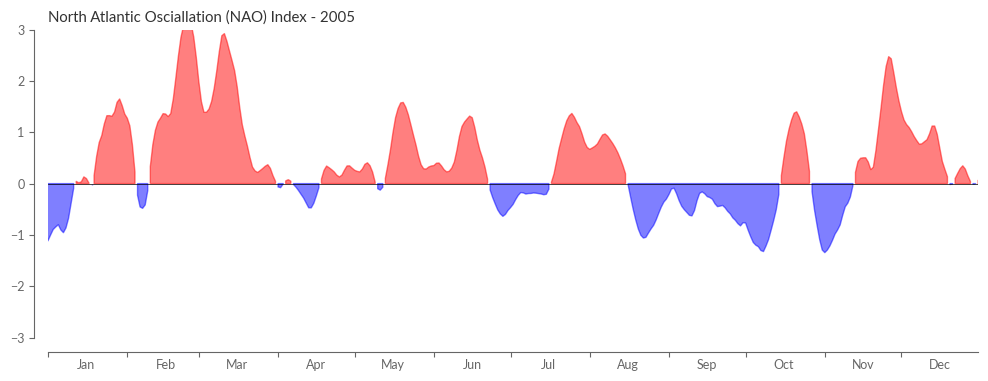

In [76]:
year = 2005

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(nao_index_smooth.time, 0, nao_index_smooth, where=nao_index_smooth > 0, color="red", alpha=0.5)
ax.fill_between(nao_index_smooth.time, 0, nao_index_smooth, where=nao_index_smooth < 0, color="blue", alpha=0.5)
ax.axhline(0, color="k", linewidth=0.5)
ax.set_title("North Atlantic Osciallation (NAO) Index - {}".format(year))
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_ylim(-3, 3)

xlim1 = dt.datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
xlim2 = dt.datetime.strptime(f"{year}-12-31", "%Y-%m-%d")
ax.set_xlim(xlim1, xlim2)
center_labels_between_xticks(ax)
sns.despine(ax=ax, offset=10)

## Conclusion

This tutorial illuminated the process of extracting both the ENSO and NAO indices from ERA5 data. We also touched upon the methodology of investigating teleconnections, demonstrated with an surface temperature teleconnections of ENSO.